Thermal Power (MW): 5.10
Gross Electrical Power (MW): 2.24
Net Electrical Power (MW): -7.76
Neutron Flux (n/cm^2.s): 2.55e+06
Peaking Factor: 1.62
Primary Sodium Core Inlet Temperature (°C): 400.00
Primary Sodium Core Outlet Temperature (°C): 560.00
Secondary Sodium SG Inlet Temperature (°C): 550.00
Superheated Steam Temperature (°C): 512.00
Total Mass Flow Rate (kg/s): 1641.998491010474
Radial Peaking Factor (Kr): 1.3
Effective Core Height (m): 0.5666666666666667


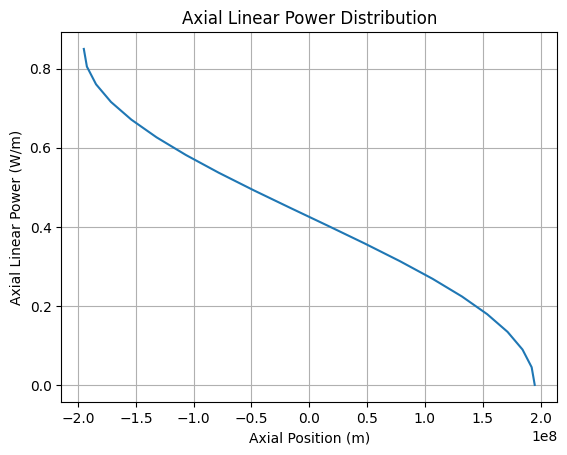

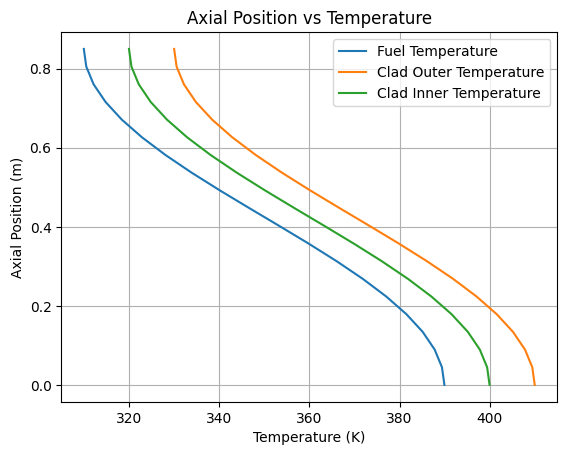

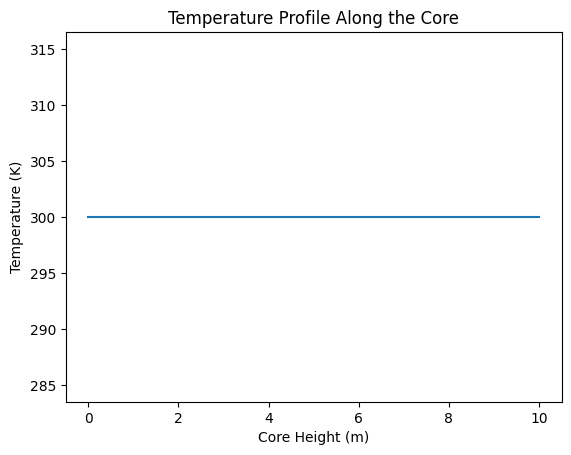

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

#Reactor parameter Formulas and calculation
# Constants and initial data
# Estimated values
mass_flow_rate = 25.1147  # kg/s
specific_heat_capacity = 1268  # J/kg·K (specific heat capacity of sodium)
temperature_inlet = 400  # °C (Primary sodium core inlet temperature)
temperature_outlet = 560  # °C (Primary sodium core outlet temperature)
gross_efficiency = 0.44  # (fraction)
auxiliary_power = 10  # MW

# Thermal Power Calculation
thermal_power = mass_flow_rate * specific_heat_capacity * (temperature_outlet - temperature_inlet) / 1e6  # in MW
print(f"Thermal Power (MW): {thermal_power:.2f}")

# Gross Electrical Power Calculation
gross_electrical_power = gross_efficiency * thermal_power
print(f"Gross Electrical Power (MW): {gross_electrical_power:.2f}")

# Net Electrical Power Calculation
net_electrical_power = gross_electrical_power - auxiliary_power
print(f"Net Electrical Power (MW): {net_electrical_power:.2f}")

# Neutron Flux Calculation
macroscopic_fission_cross_section = 0.1  # cm^-1
core_volume = 1e5  # cm^3
average_energy_per_fission = 200e-6  # J

# Neutron flux (n/cm^2.s)
neutron_flux = thermal_power * 1e6 / (macroscopic_fission_cross_section * core_volume * average_energy_per_fission)
print(f"Neutron Flux (n/cm^2.s): {neutron_flux:.2e}")

# Peaking Factor Calculation
axial_peaking_factor = 1.1
radial_peaking_factor = 1.47

# Peaking Factor
peaking_factor = axial_peaking_factor * radial_peaking_factor
print(f"Peaking Factor: {peaking_factor:.2f}")

# Temperatures
print(f"Primary Sodium Core Inlet Temperature (°C): {temperature_inlet:.2f}")
print(f"Primary Sodium Core Outlet Temperature (°C): {temperature_outlet:.2f}")

# Secondary Sodium SG Inlet Temperature
secondary_sodium_sg_inlet_temp = 550  # °C
print(f"Secondary Sodium SG Inlet Temperature (°C): {secondary_sodium_sg_inlet_temp:.2f}")

# Superheated Steam Temperature
superheated_steam_temp = 512  # °C
print(f"Superheated Steam Temperature (°C): {superheated_steam_temp:.2f}")


#End of Reactor Formulas and parameter Calculation

# Constants
PI = np.pi
rho_coolant = 1000  # Coolant density (kg/m^3) - adjust based on coolant type
v_coolant = 5  # Coolant velocity (m/s) - adjust based on operating conditions
q_avg = 1.0e8  # Average linear power density (W/m^3)
kz_max = 1.5  # Example value for axial peaking factor
kr_max = 1.3  # Example value for radial peaking factor
Cp_coolant = 4200  # Specific heat of coolant (J/kg-K)
T_inlet = 350  # Inlet temperature (K)
T_outlet = 550  # Outlet temperature (K)
nodes = 20  # Number of nodes for axial calculations

# Fuel Assembly Class
class FuelAssembly:
    def __init__(self, num_pins, pin_pitch, pin_radius, clad_inner_diameter, clad_outer_diameter, pellet_diameter, sa_length, active_core_length):
        self.num_pins = num_pins
        self.pin_pitch = pin_pitch
        self.pin_radius = pin_radius
        self.clad_inner_diameter = clad_inner_diameter
        self.clad_outer_diameter = clad_outer_diameter
        self.pellet_diameter = pellet_diameter
        self.sa_length = sa_length
        self.active_core_length = active_core_length

    def calculate_flow_area(self):
        flow_area = PI * (self.pin_pitch**2 - self.clad_outer_diameter**2) * self.num_pins / 4
        return flow_area

# Core Class
class Core:
    def __init__(self, num_fuel_sa, fuel_sa):
        self.num_fuel_sa = num_fuel_sa  # Number of fuel subassemblies
        self.fuel_sa = fuel_sa  # Instance of the FuelAssembly class

    def calculate_core_flow_area(self):
        total_flow_area = self.fuel_sa.calculate_flow_area() * self.num_fuel_sa
        return total_flow_area

    def calculate_mass_flow_rate(self):
        core_flow_area = self.calculate_core_flow_area()
        return rho_coolant * v_coolant * core_flow_area

    def calculate_axial_power_distribution(self, z):
        # Cosine shape for power distribution
        return kz_max * np.cos(PI * z / self.fuel_sa.active_core_length)

    def calculate_radial_peaking_factor(self):
        return kr_max

    def calculate_effective_core_height(self):
        # Iterative method to calculate effective core height
        # For simplicity, assume heff = active_core_length / kz_max
        return self.fuel_sa.active_core_length / kz_max

# Initialize parameters from the previous implementation
num_pins = 217
pin_pitch = 7.773e-3  # meters
clad_inner_diameter = 5.65e-3  # meters
clad_outer_diameter = 6.55e-3  # meters
pellet_diameter = 5.42e-3  # meters
sa_length = 4.3  # meters
active_core_length = 0.85  # meters
num_fuel_sa = 54 + 56  # Number of fuel SAs in the inner and outer core

# Create fuel assembly object
fuel_sa = FuelAssembly(num_pins, pin_pitch, pellet_diameter / 2, clad_inner_diameter, clad_outer_diameter, pellet_diameter, sa_length, active_core_length)

# Create core object
core = Core(num_fuel_sa, fuel_sa)

# Calculate total mass flow rate
mass_flow_rate = core.calculate_mass_flow_rate()
print("Total Mass Flow Rate (kg/s):", mass_flow_rate)

# Calculate axial and radial peaking factors
axial_peaking_factor = core.calculate_axial_power_distribution(np.linspace(0, active_core_length, nodes))
radial_peaking_factor = core.calculate_radial_peaking_factor()
print("Radial Peaking Factor (Kr):", radial_peaking_factor)

# Calculate effective height of active core
effective_core_height = core.calculate_effective_core_height()
print("Effective Core Height (m):", effective_core_height)

# Axial linear power distribution
z = np.linspace(0, active_core_length, nodes)
q_prime = q_avg * axial_peaking_factor * radial_peaking_factor

# Plot axial linear power distribution
plt.figure()
plt.plot(q_prime, z)
plt.xlabel('Axial Position (m)')
plt.ylabel('Axial Linear Power (W/m)')
plt.title('Axial Linear Power Distribution')
plt.grid(True)
plt.show()


# Simplified temperature distribution calculations
T_fuel = T_inlet + q_prime * sa_length / (rho_coolant * Cp_coolant * v_coolant)
T_clad_outer = T_fuel + (T_outlet - T_inlet) / 10
T_clad_inner = T_clad_outer - (T_outlet - T_inlet) / 20

# Plot temperature against axial position
plt.figure()
plt.plot(T_fuel, z, label="Fuel Temperature")
plt.plot(T_clad_outer, z, label="Clad Outer Temperature")
plt.plot(T_clad_inner, z, label="Clad Inner Temperature")
plt.ylabel('Axial Position (m)')
plt.xlabel('Temperature (K)')
plt.title('Axial Position vs Temperature')
plt.legend()
plt.grid(True)
plt.show()


#Advancing Parameters

# Define all necessary constants and variables
num_segments = 100
inlet_temperature = 300  # value in Kelvin
initial_velocity_value = 0.1  # value in m/s
rho = 1000  # density in kg/m^3
P = np.linspace(1e5, 1e6, num_segments)  # pressure gradient
mu = 0.001  # dynamic viscosity in Pa.s
F = np.zeros(num_segments)  # external force
cp = 4184  # specific heat capacity in J/(kg.K)
k = 0.6  # thermal conductivity in W/(m.K)
Q = np.zeros(num_segments)  # heat source term
simulation_time = 1000  # simulation time in seconds
core_height = 10  # core height in meters

# Define initial conditions
initial_temperature = np.full((num_segments,), inlet_temperature)
initial_velocity = np.full((num_segments,), initial_velocity_value)
initial_conditions = np.concatenate([initial_velocity, initial_temperature])

# Define the model function
def model(t, y):
    v, T = y[:num_segments], y[num_segments:]
    dvdt = momentum_equation(rho, v, P, mu, F)
    dTdt = energy_equation(rho, cp, T, v, k, Q)
    return np.concatenate([dvdt, dTdt])

# implementations for some functions
def momentum_equation(rho, v, P, mu, F):
    # I am to Implement my actual momentum equation here
    return np.zeros_like(v)  # Placeholder

def energy_equation(rho, cp, T, v, k, Q):
    # Implement actual energy equation here
    return np.zeros_like(T)  # Placeholder

# Solve the system of ODEs
solution = solve_ivp(model, [0, simulation_time], initial_conditions, method='RK45')

# Check if solution was successful
if solution.success:
    # Extract and plot the results
    temperatures = solution.y[num_segments:, :]
    velocities = solution.y[:num_segments, :]
    plt.plot(np.linspace(0, core_height, num_segments), temperatures[:, -1])
    plt.xlabel('Core Height (m)')
    plt.ylabel('Temperature (K)')
    plt.title('Temperature Profile Along the Core')
    plt.show()
else:
    print("Integration failed:", solution.message)